# Plot Transect Averages (Figures 10 & 11)

In [2]:
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')

import numpy as np
from matplotlib import gridspec

import pandas as pd
import xarray as xr
import pygridgen
import geopandas
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io import shapereader
import cartopy.io.img_tiles as cimgt

from scipy.stats import geom
from glob import glob

import cmocean.cm as cmo
import xroms
import os
import calendar

from scipy.spatial import Delaunay
from scipy.interpolate import LinearNDInterpolator
from scipy.interpolate import NearestNDInterpolator
from shapely.geometry.polygon import LinearRing

import time
import xesmf as xe


In [3]:
sreaddir = 'roms_latlonSlices/'
creaddir = 'coawst_latlonSlices/'

yvec = [2021, 2021, 2021, 2021, 2021, 2021, 2022, 2022, 2022, 2022, 2022, 2022]
mvec = [7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6]

In [4]:
smlon_avgs = [] # ROMS longitude averages
smlat_avgs = [] # ROMS latitude averages
cmlon_avgs = [] # COAWST longitude averages
cmlat_avgs = [] # COAWST latitude averages

for j in range(len(yvec)):
    sdstr = str(yvec[j]) + f"{mvec[j]:02d}"
    calmon = calendar.month_abbr[mvec[j]]
    cdstr_lon = str(yvec[j]) + calmon + 'lon_slices.nc'
    cdstr_lat = str(yvec[j]) + calmon + 'lat_slices.nc'
    print(sdstr)
    sflon = sreaddir + 'lon_slices_' + sdstr + '.nc'
    sflat = sreaddir + 'lat_slices_' + sdstr + '.nc'
    cflon = creaddir + cdstr_lon
    cflat = creaddir + cdstr_lat
    smlon_avgs.append(xr.open_dataset(sflon))
    smlat_avgs.append(xr.open_dataset(sflat))
    cmlon_avgs.append(xr.open_dataset(cflon))
    cmlat_avgs.append(xr.open_dataset(cflat))



202107
202108
202109
202110
202111
202112
202201
202202
202203
202204
202205
202206


In [5]:
smlon_avgs[0].temp

<xarray.DataArray 'temp' (lon_vals: 5, s_rho: 40, eta_rho: 300)> Size: 240kB
[60000 values with dtype=float32]
Coordinates:
  * s_rho       (s_rho) float64 320B -0.9875 -0.9625 -0.9375 ... -0.0375 -0.0125
    lon_rho     (lon_vals, eta_rho) float64 12kB ...
    lat_rho     (lon_vals, eta_rho) float64 12kB ...
    xi_rho      (lon_vals) int32 20B ...
  * eta_rho     (eta_rho) int32 1kB 0 1 2 3 4 5 6 ... 294 295 296 297 298 299
    ocean_time  datetime64[ns] 8B ...
    z_rho       (lon_vals, s_rho, eta_rho) float64 480kB ...
    z_rho0      (lon_vals, s_rho, eta_rho) float64 480kB ...
Dimensions without coordinates: lon_vals
Attributes:
    long_name:  potential temperature
    units:      Celsius
    time:       ocean_time
    location:   face
    field:      temperature, scalar, series

In [6]:
solo_mlons = xr.concat(smlon_avgs, dim='month')
solo_mlats = xr.concat(smlat_avgs, dim='month')

cpd_mlons = xr.concat(cmlon_avgs, dim='month')
cpd_mlats = xr.concat(cmlat_avgs, dim='month')

In [7]:
# Annual averages

alon_avg = solo_mlons.mean(dim='month')
alat_avg = solo_mlats.mean(dim='month')

calon_avg = cpd_mlons.mean(dim='month')
calat_avg = cpd_mlats.mean(dim='month')

In [8]:
# Add depth coordinate for plotting
calon_avg = calon_avg.assign_coords(z_rho0=alon_avg.z_rho0)
calat_avg = calat_avg.assign_coords(z_rho0=alat_avg.z_rho0)

In [9]:
fname = 'test_roms_temp.nc'
test_ds = xr.open_dataset(fname)

In [11]:
# grab lon/lat to plot extent of dipole

lonc0 = test_ds.lon_rho[210,285].values
lonc1 = test_ds.lon_rho[229,285].values
lonc2 = test_ds.lon_rho[229,311].values
lonc3 = test_ds.lon_rho[210,311].values

latc0 = test_ds.lat_rho[210,285].values
latc1 = test_ds.lat_rho[229,285].values
latc2 = test_ds.lat_rho[229,311].values
latc3 = test_ds.lat_rho[210,311].values

lonring = np.hstack((lonc0, lonc1, lonc2, lonc3))
latring = np.hstack((latc0, latc1, latc2, latc3))

ring = LinearRing(list(zip(lonring, latring)))

# Average lon/lat for plotting later
tlon_avg = np.mean(lonring)
tlat_avg = np.mean(latring)

In [14]:
# Apply xroms function to get z-coordinate information
test_ds, xgrid = xroms.roms_dataset(test_ds)

(33.0, 37.5)

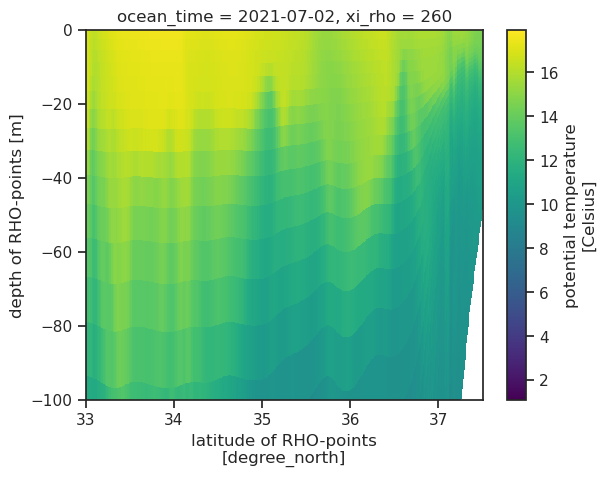

In [15]:
test_ds.temp.isel(xi_rho=260, eta_rho=slice(0,344)).plot(x='lat_rho',y='z_rho')
plt.ylim([-100, 0])
plt.xlim([33, 37.5])

In [16]:
ccalon_avgs = []
vslices = [260, 275, 290, 305, 320]

for i in range(len(calon_avg.lon_vals)):
    cgrab = calon_avg.isel(lon_vals=i)

    z_grab = test_ds.z_rho.isel(ocean_time=0, xi_rho=vslices[i], eta_rho=slice(0,350))
    z_grab = z_grab.fillna(0)
    nu_da = xr.DataArray(
        data=cgrab.temp.values,
        dims=["s_rho", "eta_rho"],
        coords=dict(
            s_rho=(["s_rho"], test_ds.s_rho.values),
            eta_rho=(["eta_rho"], test_ds.eta_rho.isel(eta_rho=slice(0,350)).values),
            lat_rho=(["eta_rho"], test_ds.lat_rho.isel(xi_rho=vslices[i], eta_rho=slice(0,350)).values),
            z_rho=(["s_rho", "eta_rho"], z_grab.values),
        ),
        attrs=dict(
            description="Temperature.",
            units="degC",
        ),
    )
    ccalon_avgs.append(nu_da)

In [20]:
ccalat_avgs = []
# vslices = [185, 200, 215, 230, 245]
vslices = [245, 230, 215, 200, 185]

for i in range(len(calat_avg.lat_vals)):
    cgrab = calat_avg.isel(lat_vals=i)

    z_grab = test_ds.z_rho.isel(ocean_time=0, eta_rho=vslices[i], xi_rho=slice(0,350))
    z_grab = z_grab.fillna(0)
    nu_da = xr.DataArray(
        data=cgrab.temp.values,
        dims=["s_rho", "xi_rho"],
        coords=dict(
            s_rho=(["s_rho"], test_ds.s_rho.values),
            eta_rho=(["xi_rho"], test_ds.xi_rho.isel(xi_rho=slice(0,350)).values),
            lon_rho=(["xi_rho"], test_ds.lon_rho.isel(eta_rho=vslices[i], xi_rho=slice(0,350)).values),
            z_rho=(["s_rho", "xi_rho"], z_grab.values),
        ),
        attrs=dict(
            description="Temperature.",
            units="degC",
        ),
    )
    ccalat_avgs.append(nu_da)

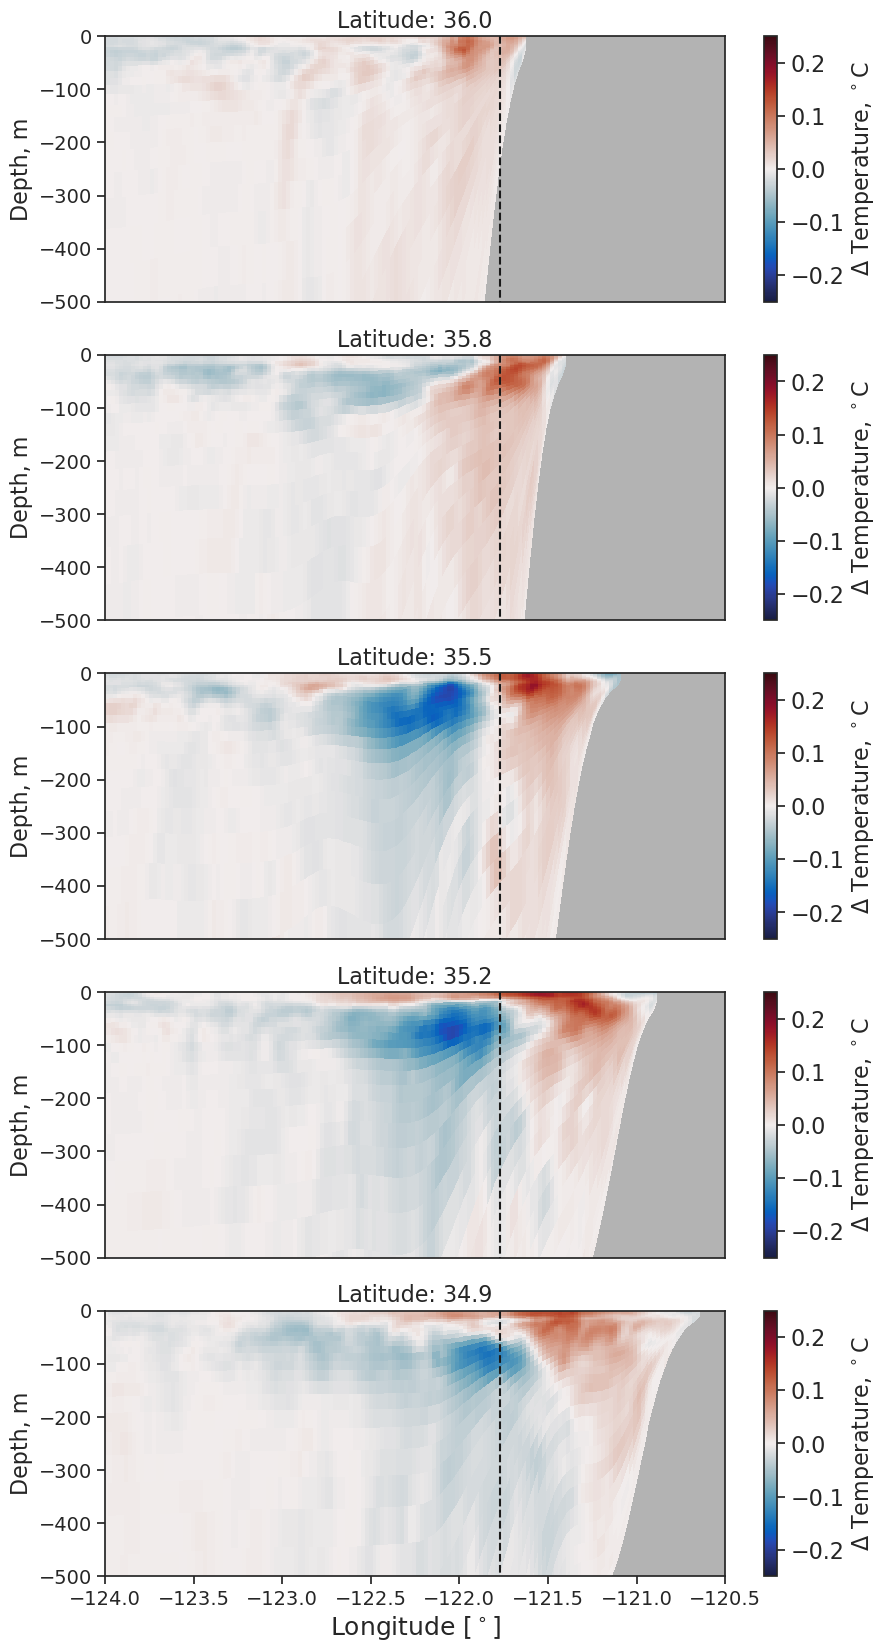

In [21]:
fig = plt.figure(figsize=(10, 20))

nplots = 5
gs = gridspec.GridSpec(nplots, 1, height_ratios=[1, 1, 1, 1, 1], hspace=0.2)

vslices = [185, 200, 215, 230, 245]
vlats = []
for vidx in range(len(vslices)):
    vlats.append(np.mean(alat_avg.lat_rho[vidx,:].values))

for i in range(nplots):
    ax = plt.subplot(gs[i])

    ax.set_facecolor((0.7, 0.7, 0.7))

    cplot = ccalat_avgs[i]
    pc = cplot.plot(x='lon_rho', y='z_rho', vmin=-0.25, vmax=0.25,
                                    cmap=cmo.balance, add_colorbar=False)
    
    cb = fig.colorbar(pc)
    cb.set_label('$\Delta$ Temperature, $^\circ$C', fontsize=16)
    cb.ax.tick_params(labelsize=16)

    
    ax.set_ylabel('Depth, m', fontsize=16)
    
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.tick_params(axis='both', which='minor', labelsize=14)
    if i<(nplots-1):
        ax.set_xticks([])
        ax.set_xlabel('')
    else:
        ax.set_xlabel('Longitude [$^\circ$]', fontsize=18)

    ax.plot([tlon_avg, tlon_avg], [0, -1000], 'k--')
    
    ax.set_ylim([-500, 0])
    ax.set_xlim([-124, -120.5])
    ax.set_title('Latitude: %0.1f' % vlats[i], fontsize=16)

## Read in surface averaged model outputs

In [26]:
sroot = 'Turbine_outputs_SoloROMS/'
croot = 'Turbine_outputs_CoupledCOAWST/'

In [27]:
# Read in ROMS and COAWST model outputs
solo_dss = []
cpd_dss = []

for j in range(len(mvec)):
    calmon = calendar.month_abbr[mvec[j]]
    dstr = str(yvec[j]) + calmon
    sds = xr.open_dataset(sroot + dstr + '_temp_SpatialAvg.nc')
    cds = xr.open_dataset(croot + dstr + '_temp_SpatialAvg.nc')
    solo_dss.append(sds)
    cpd_dss.append(cds)


In [28]:
solo_avg = []
cpd_avg = []

for ds in solo_dss:
    x = ds.temp
    solo_avg.append(xr.DataArray(x,dims=('eta_rho','xi_rho')))

for ds in cpd_dss:
    x = ds.temp
    cpd_avg.append(xr.DataArray(x,dims=('eta_rho','xi_rho')))
    
solo_ann_concat = xr.concat(solo_avg, dim='time')
cpd_ann_concat = xr.concat(cpd_avg, dim='time')


In [34]:
# Extra colors for plotting different transects

n_lines = 6
cmap = matplotlib.colormaps['RdPu']

# Take colors at regular intervals spanning the colormap.
rdpu_colors = cmap(np.linspace(0, 1, n_lines))

turb_grab = cmo.turbid(np.arange(0,1,1/6))
turb_rev = list(reversed(turb_grab))

In [41]:
lp_letters = ['a', 'b', 'c', 'd', 'e']
rp_letters = ['g', 'h', 'i', 'j', 'k']

[0.47482065 0.32359888 0.21950271 1.        ]
[0.63151166 0.43919252 0.23194585 1.        ]
[0.74963858 0.59343284 0.27884576 1.        ]
[0.82922751 0.77538321 0.44177277 1.        ]
[0.91282478 0.96390535 0.67234889 1.        ]


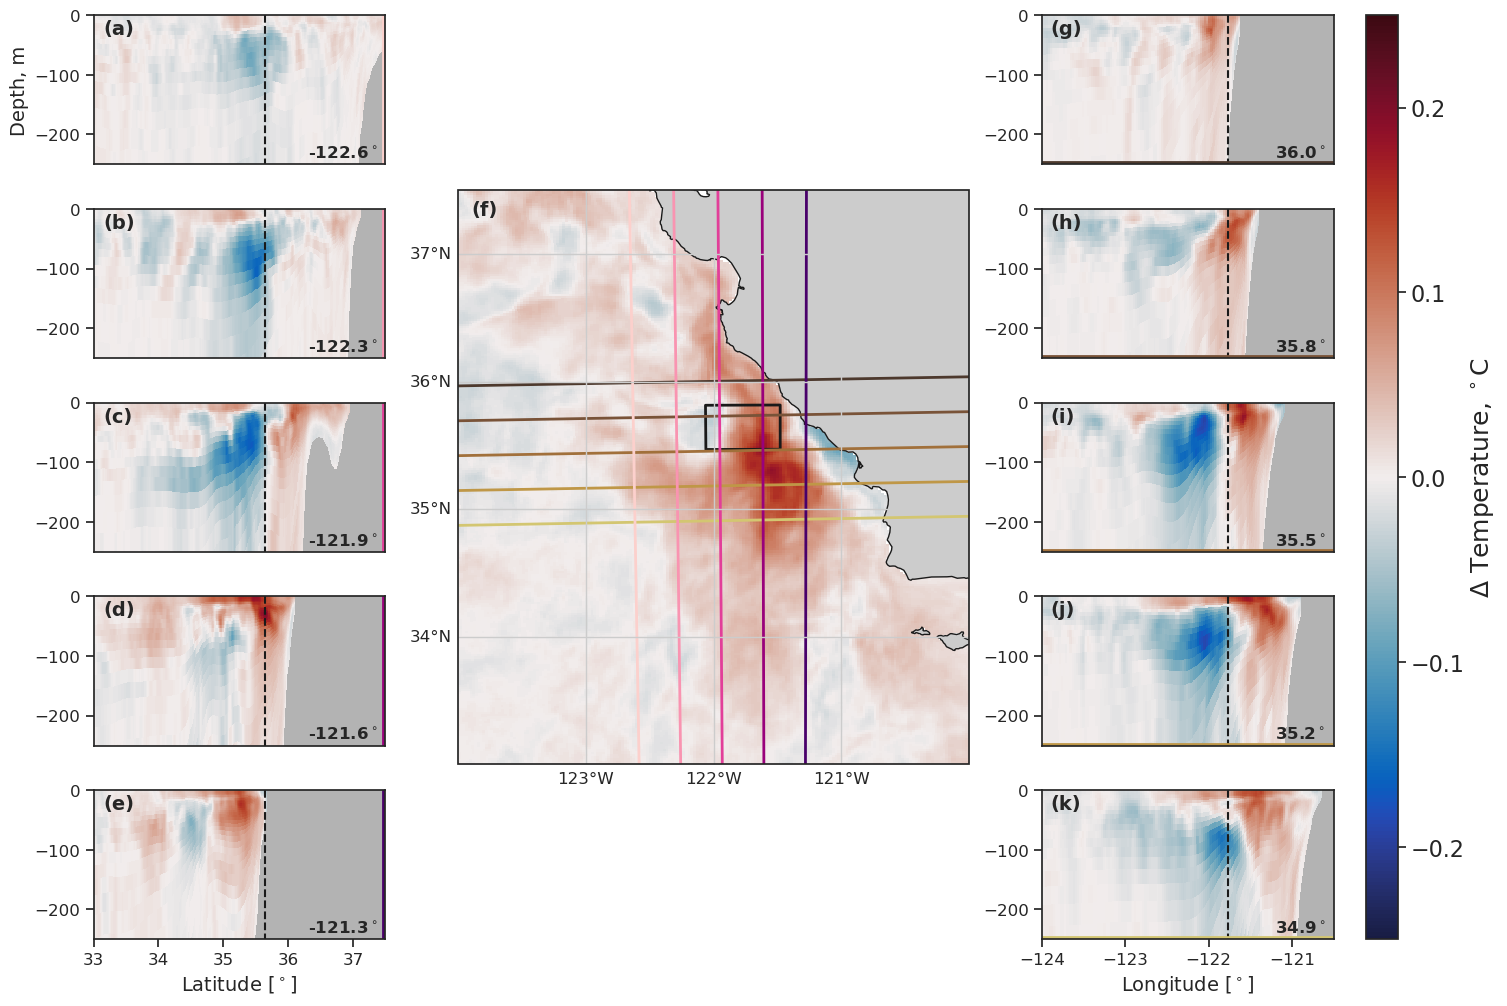

In [42]:
# Combined Figure 10

proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(16,12))
gs0 = gridspec.GridSpec(1, 3, figure=fig, width_ratios=[1, 1.75, 1])

#------------------------------------------------------------------------------------------------#
#------------------------------------------------------------------------------------------------#
#------------------------------------------------------------------------------------------------#

gs00 = gridspec.GridSpecFromSubplotSpec(5, 1, subplot_spec=gs0[0], hspace=0.3)

nplots = 5

vslices = [260, 275, 290, 305, 320]
vlons = []
for vidx in range(len(vslices)):
    vlons.append(np.mean(alon_avg.lon_rho[vidx,:].values))

for i in range(nplots):
    ax = plt.subplot(gs00[i])

    ax.set_facecolor((0.7, 0.7, 0.7))

    cplot = ccalon_avgs[i]
    pc = cplot.plot(x='lat_rho', y='z_rho', vmin=-0.25, vmax=0.25,
                                    cmap=cmo.balance, add_colorbar=False)
    

    if i==0:
        ax.set_ylabel('Depth, m', fontsize=14)
    else:
        ax.set_ylabel('')
    
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.tick_params(axis='both', which='minor', labelsize=12)
    if i<(nplots-1):
        ax.set_xticks([])
        ax.set_xlabel('')
    else:
        ax.set_xlabel('Latitude [$^\circ$]', fontsize=14)

    ax.plot([tlat_avg, tlat_avg], [0, -1000], 'k--')
    ax.plot([37.47, 37.47], [0, -1000], color=rdpu_colors[i+1], linewidth=2)
    
    ax.set_ylim([-250, 0])
    ax.set_xlim([33, 37.5])
    ax.text(36.3, -240, '%0.1f$^\circ$' % vlons[i], fontsize=12, fontweight='bold')
    ax.text(33.15, -32, '(%s)' % lp_letters[i], fontsize=14, fontweight='demibold')

#------------------------------------------------------------------------------------------------#
#------------------------------------------------------------------------------------------------#
#------------------------------------------------------------------------------------------------#

# Plot plan view SST changes
gs01 = gs0[1].subgridspec(1, 1)

ax = plt.subplot(gs01[0], projection=proj)

coast_10m = cfeature.NaturalEarthFeature(
    "physical", "land", "10m", edgecolor="k", facecolor="0.8"
)
ax.add_feature(coast_10m)

pctr = cpd_ann_concat.mean(dim='time').plot(x='lon_rho', y='lat_rho',
                                 ax=ax, transform=ccrs.PlateCarree(),
                                 cmap=cmo.balance, vmin=-0.25, vmax=0.25,
                                 add_colorbar=False)

pctr.set_clim(-0.25, 0.25)

ax.add_geometries([ring], ccrs.PlateCarree(), facecolor='none', edgecolor='k', linewidth=2)

gl = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False,
                    xlocs=np.arange(-130,-115, 1.0), ylocs=np.arange(31, 46, 1.0))
 
# manipulate `gridliner` object to change locations of labels
gl.top_labels = False
gl.right_labels = False

vslices = [185, 200, 215, 230, 245]
k = 1
for vidx in vslices:
    wlon = test_ds.lon_rho[vidx,0].values.item()
    elon = test_ds.lon_rho[vidx,450].values.item()
    wlat = test_ds.lat_rho[vidx,0].values.item()
    elat = test_ds.lat_rho[vidx,450].values.item()

    ax.plot([wlon, elon], [wlat, elat], color=turb_grab[k], linewidth=2, transform=ccrs.PlateCarree())
    k+=1

vslices = [260, 275, 290, 305, 320]
k2 = 1
for vidx in vslices:
    wlon = test_ds.lon_rho[0,vidx].values.item()
    elon = test_ds.lon_rho[550,vidx].values.item()
    wlat = test_ds.lat_rho[0,vidx].values.item()
    elat = test_ds.lat_rho[550,vidx].values.item()

    ax.plot([wlon, elon], [wlat, elat], color=rdpu_colors[k2], linewidth=2, transform=ccrs.PlateCarree())
    k2+=1

ax.set_title('')
ax.set_extent([-124, -120, 33, 37.5], crs=ccrs.PlateCarree())
ax.text(-123.9, 37.3, '(f)', fontsize=14, fontweight='demibold')

#------------------------------------------------------------------------------------------------#
#------------------------------------------------------------------------------------------------#
#------------------------------------------------------------------------------------------------#

# Latitude slices

gs02 = gs0[2].subgridspec(5,1, hspace=0.3)

vslices = [185, 200, 215, 230, 245]
vlats = []
for vidx in range(len(vslices)):
    vlats.append(np.mean(alat_avg.lat_rho[vidx,:].values))

for i in range(nplots):
    ax = plt.subplot(gs02[i])

    ax.set_facecolor((0.7, 0.7, 0.7))
    cplot = ccalat_avgs[i]
    pc = cplot.plot(x='lon_rho', y='z_rho', vmin=-0.25, vmax=0.25,
                                    cmap=cmo.balance, add_colorbar=False)
    
   
    ax.set_ylabel('', fontsize=12)
    
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.tick_params(axis='both', which='minor', labelsize=12)
    if i<(nplots-1):
        ax.set_xticks([])
        ax.set_xlabel('')
    else:
        ax.set_xlabel('Longitude [$^\circ$]', fontsize=14)

    ax.plot([tlon_avg, tlon_avg], [0, -1000], 'k--')
    print(turb_rev[i+1])
    ax.plot([-124, -120.5], [-247, -247], color=turb_rev[i], linewidth=2)

    ax.set_ylim([-250, 0])
    ax.set_xlim([-124, -120.5])
    ax.text(-121.2, -240, '%0.1f$^\circ$' % vlats[i], fontsize=12, fontweight='bold')
    ax.text(-123.9, -32, '(%s)' % rp_letters[i], fontsize=14, fontweight='demibold')
#------------------------------------------------------------------------------------------------#
#------------------------------------------------------------------------------------------------#
#------------------------------------------------------------------------------------------------#

# Colorbar
cax = fig.add_axes([0.92, 0.11, 0.02, 0.77])
cbar = plt.colorbar(pctr, cax=cax, aspect=0.2)
cbar.ax.set_ylabel('$\Delta$ Temperature, $^\circ$C', fontsize=18)
cbar.ax.tick_params(labelsize=16)

plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'

fig.savefig('Figure_10.png', format='png', dpi=300, bbox_inches='tight')

## Calculate depth averaged temperature of upper 250 m (Fig. 11)

In [45]:
# Grab depth values for centered latitude transect
z_grab = alat_avg.temp.isel(lat_vals=3).z_rho0
z_ints = np.linspace(-250,0,251)

In [47]:
# Get center transect temperature estimate for solo and coupled simulations
solo_interp = []
cpd_interp = []

stgrab = alat_avg.temp.isel(lat_vals=3).values
ctgrab = ccalat_avgs[3].values

sz_grab = alat_avg.temp.isel(lat_vals=3).z_rho0
cz_grab = ccalat_avgs[3].z_rho

z_ints = np.linspace(-250,0,251)

for i in range(stgrab.shape[1]):
    solo_interp.append(np.interp(z_ints, sz_grab[:,i], stgrab[:,i]))
    cpd_interp.append(np.interp(z_ints, cz_grab[:,i], ctgrab[:,i]))
    
roms_mztemp = np.asarray(solo_interp)
coawst_mztemp = np.asarray(cpd_interp)

In [53]:
solo_ida = xr.DataArray(
    data=roms_mztemp,
    dims=["lon_rho", "z_rho"],
    coords=dict(
        lon_rho=(["lon_rho"], ccalat_avgs[3].lon_rho.values),
        z_rho=(["z_rho"], z_ints),
    ),
    attrs=dict(
        description="Delta Temperature.",
        units="degC",
    ),
)

cpd_ida = xr.DataArray(
    data=coawst_mztemp,
    dims=["lon_rho", "z_rho"],
    coords=dict(
        lon_rho=(["lon_rho"], ccalat_avgs[3].lon_rho.values),
        z_rho=(["z_rho"], z_ints),
    ),
    attrs=dict(
        description="Delta Temperature.",
        units="degC",
    ),
)

# Calculate mean and st.dev. of temperatures over upper 250 m of water column
us250 = solo_ida.mean(dim='z_rho')
uc250 = cpd_ida.mean(dim='z_rho')
rs250 = solo_ida.std(dim='z_rho')
cs250 = cpd_ida.std(dim='z_rho')

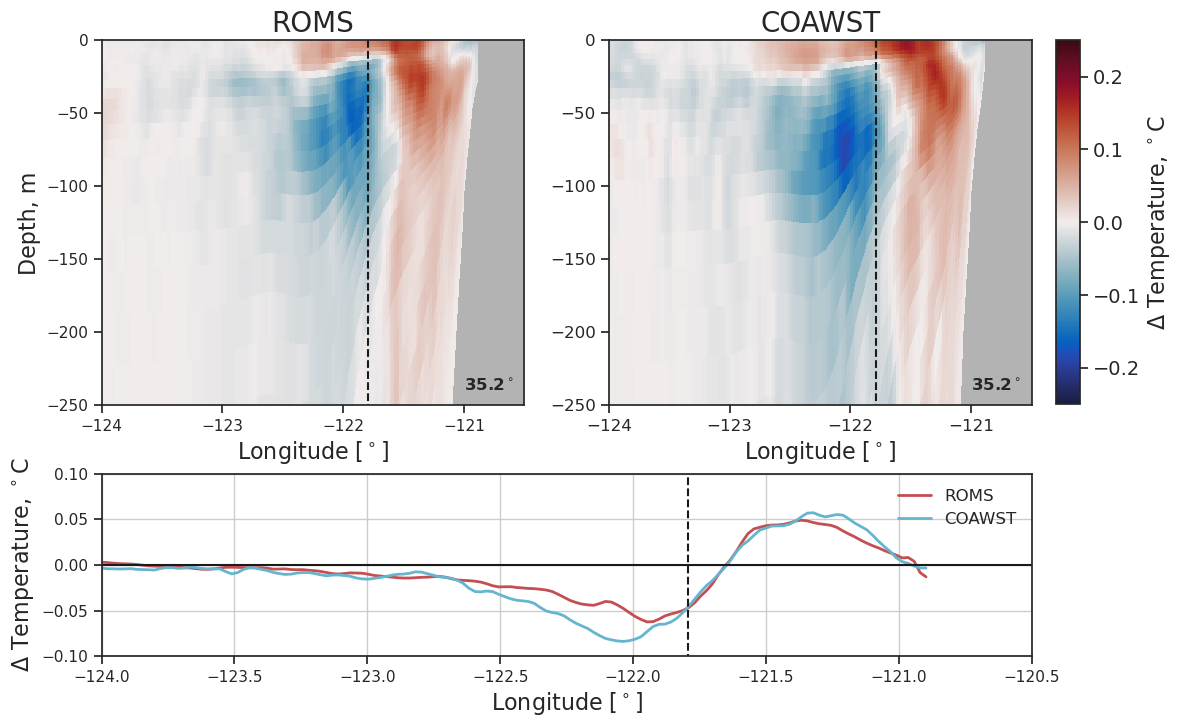

In [59]:
fig = plt.figure(figsize=(12, 8))

gs = gridspec.GridSpec(2, 2, width_ratios=[1, 1], wspace=0.2, height_ratios=[1, 0.5], hspace=0.25)

#---------------------------------------------------------------------#
ax = plt.subplot(gs[0, 0])
ax.set_facecolor((0.7, 0.7, 0.7))

alat_avg.temp.isel(lat_vals=3).plot(x='lon_rho', y='z_rho0', cmap=cmo.balance,
                                    vmin=-0.25, vmax=0.25, add_colorbar=False)
ax.set_ylim([-250, 0])
ax.plot([tlon_avg, tlon_avg], [0, -1000], 'k--')

ax.set_title('ROMS', fontsize=20)
ax.set_xlim([-124, -120.5])
ax.set_ylabel('Depth, m', fontsize=16)
ax.set_xticks([-124, -123, -122, -121])
ax.set_xlabel('Longitude [$^\circ$]', fontsize=16)
ax.text(-121, -240, '%0.1f$^\circ$' % vlats[3], fontsize=12, fontweight='bold')

#---------------------------------------------------------------------#
ax = plt.subplot(gs[0, 1])
ax.set_facecolor((0.7, 0.7, 0.7))

cplot = ccalat_avgs[3]
pc = cplot.plot(x='lon_rho', y='z_rho', vmin=-0.25, vmax=0.25,
                            cmap=cmo.balance, add_colorbar=False)
ax.set_ylabel('', fontsize=12)

ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=12)

ax.set_xticks([-124, -123, -122, -121])
ax.set_xlabel('Longitude [$^\circ$]', fontsize=16)

ax.plot([tlon_avg, tlon_avg], [0, -1000], 'k--')

ax.set_ylim([-250, 0])
ax.set_xlim([-124, -120.5])
ax.set_title('COAWST', fontsize=20)
ax.text(-121, -240, '%0.1f$^\circ$' % vlats[3], fontsize=12, fontweight='bold')

#---------------------------------------------------------------------#
# colorbar
# cax = fig.add_axes([0.92, 0.11, 0.02, 0.77])
cax = fig.add_axes([0.92, 0.425, 0.02, 0.455])
cbar = plt.colorbar(pc, cax=cax, aspect=0.2)
cbar.ax.set_ylabel('$\Delta$ Temperature, $^\circ$C', fontsize=16)
cbar.ax.tick_params(labelsize=14)

#---------------------------------------------------------------------#
ax = plt.subplot(gs[1, :])

us250.plot(label='ROMS', color='r', linewidth=2)
uc250.plot(label='COAWST', color='c', linewidth=2)

ax.plot([-124, -120.5], [0, 0], 'k')

ax.grid()
ax.legend(fontsize=12)
ax.set_xlim([-124, -120.5])
ax.set_xlabel('Longitude [$^\circ$]', fontsize=16)
ax.set_ylabel('$\Delta$ Temperature, $^\circ$C', fontsize=16)
ax.plot([tlon_avg, tlon_avg], [-100, 10], 'k--')
ax.set_ylim([-0.1, 0.1])


fig.savefig('Figure_11.png', format='png', dpi=300, bbox_inches='tight')